In [ ]:
# prepare data
import os
import glob
import json
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


paths = list(glob.iglob('data/IJCAI_2019_AAAC_train/*/*'))
for i, p in enumerate(paths):
#     with open(p, 'rb') as f:
#         image_bytes = f.read()
#         image_bytes = exif_remove(image_bytes)
#     iof = BytesIO()
#     iof.write(image_bytes)
    if p.endswith(('gif', )):
        status[i] = False
    image = Image.open(p)
    x, y = image.size
    if x < 30 or y < 30:
        status[i] = False
    if image.format == "GIF":
        status[i] = False
    if image.mode == 'RGBA':
        status[i] = False
    if image.mode != "RGB":
        status[i] = False
status = [True] * len(paths)
paths = np.array(paths)
paths = paths[status]
labels = [int(p.split('/')[-2]) for p in paths]
path_train, path_test, label_train, label_test = train_test_split(paths, labels, test_size=0.2)

In [ ]:
import torch
from torch import nn


class NoiseNet(nn.Module):
    def __init__(self, num_classes, image_size=(299, 299), channels=3):
        super().__init__()
        self.noise = nn.Parameter(torch.empty(num_classes, channels, *image_size))
        nn.init.xavier_uniform_(self.noise)
        
    def forward(self, gt, target):
        return None

In [1]:
# GAIN API
import cv2
import glob
import numpy as np
from torch import nn
from PIL import Image
import pretrainedmodels
from matplotlib import pyplot as plt


from config_gain import *
from models import drn, activations
from models.gain import GAINSolver


backbone = pretrainedmodels.__dict__[model_name]()
backbone = nn.Sequential(*list(backbone.children())[: -2])
solver = GAINSolver(backbone, num_classes, in_channels, devices=devices, 
                    activation=activations.HardConcrete(loc, temp))
solver.load_model('saved_models/best_model_GAIN model: se_resnet50 optimizer: sgd loc: -0.3 temp: 0.1.pt')

img = [Image.open(i) for i in glob.iglob('data/dev_data/*') if i.endswith('png')]
img_np = np.asarray([np.asarray(i.resize((224, 224))) for i in img])
# img_mean = img_np.mean(axis=1, keepdims=True).mean(axis=2, keepdims=True)


cls, mask = solver.predict(img)
mask = mask > 0.5
img_target = img_np.copy()
img_target[~mask.repeat(3, axis=-1)] = 0
num = mask.reshape(mask.shape[0], -1).sum(axis=-1)
num = num.reshape(mask.shape[0], 1, 1, 1).repeat(3, axis=-1)
img_mean = img_target.sum(axis=1, keepdims=True).sum(axis=2, keepdims=True) / num
img_masked = (1 - mask) * img_np + mask * img_mean

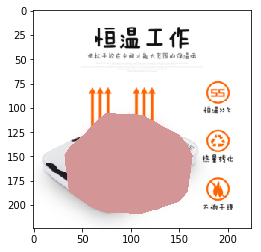

In [2]:
plt.imshow(img_masked[2].astype(np.uint8))

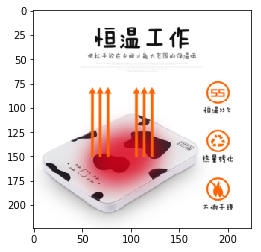

In [3]:
plt.imshow(img_np[2].astype(np.uint8))

In [4]:
np.sqrt(np.square(img_masked - img_np).mean())

34.378907639471926